In [2]:
#!pip install plotly ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

import plotly.graph_objs as go
#this will mute errors that made your final pdf less legible
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('Cityspace_Attendance_Updated.csv')
df['Date'] = pd.to_datetime(df['Date'])

#Plot 1: Comparing Average Attendance by Category (with and without name of Guest Speaker in Title)

In [13]:
def update_plot(selected_categories):
    avg_attendance_selected = df[df['Category'].isin(selected_categories)].groupby(['Category', 'Guest_Speaker']).agg({'All_Attendance': 'mean', 'Category': 'size'}).rename(columns={'Category': 'Event_Count'}).reset_index()

    # Sort the dataframe by average attendance in descending order
    avg_attendance_selected_sorted = avg_attendance_selected.sort_values(by='All_Attendance', ascending=False)

    fig = px.bar(avg_attendance_selected_sorted, y='Category', x='All_Attendance', color='Guest_Speaker',
                 barmode='group', title='Average Attendance by Category with Guest Speaker Comparison',
                 category_orders={"Category": ["A", "B", "C", "D"][::-1], "Guest_Speaker": ["Yes", "No"]},  # Reverse the order of categories
                 hover_data={'All_Attendance': True, 'Event_Count': True},
                 labels={'All_Attendance': 'Average Attendance', 'Event_Count': 'Event Count'},
                 template='plotly',
                 orientation='h',  # Set orientation to horizontal
                 color_discrete_map={'Yes': 'orange', 'No': 'black'})  # Set colors for Yes and No

    fig.show()

# Create checkboxes for categories
category_checkboxes = [widgets.Checkbox(description=category, value=False) for category in df['Category'].unique()][::-1]  # Reverse the order of categories

# Function to handle checkbox change event
def checkbox_event_handler(change):
    selected_categories = [checkbox.description for checkbox in category_checkboxes if checkbox.value]
    update_plot(selected_categories)

# Bind the event handler function to the checkboxes
for checkbox in category_checkboxes:
    checkbox.observe(checkbox_event_handler, names='value')

# Display the checkboxes vertically without extra space
category_checkboxes_vbox = widgets.VBox(category_checkboxes, layout={'display': 'flex', 'flex_flow': 'column'})
display(category_checkboxes_vbox)
print("\n")

In [14]:
update_plot([checkbox.description for checkbox in category_checkboxes if checkbox.value])

# Plot 2: Attendance vs Tickets Sold Per Event

In [15]:
df1 = pd.read_csv('Cityspace_Attendance_with_Profits_Tickets.csv')
df1['Date'] = pd.to_datetime(df1['Date'])

In [16]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Create date picker widgets for selecting the start and end dates
start_date_widget = widgets.DatePicker(description='Start Date:', value=pd.to_datetime('2019-03-01'))
end_date_widget = widgets.DatePicker(description='End Date:', value=pd.to_datetime('2024-01-01'))

# Display the date picker widgets
display(start_date_widget, end_date_widget)

DatePicker(value=Timestamp('2019-03-01 00:00:00'), description='Start Date:')

DatePicker(value=Timestamp('2024-01-01 00:00:00'), description='End Date:')

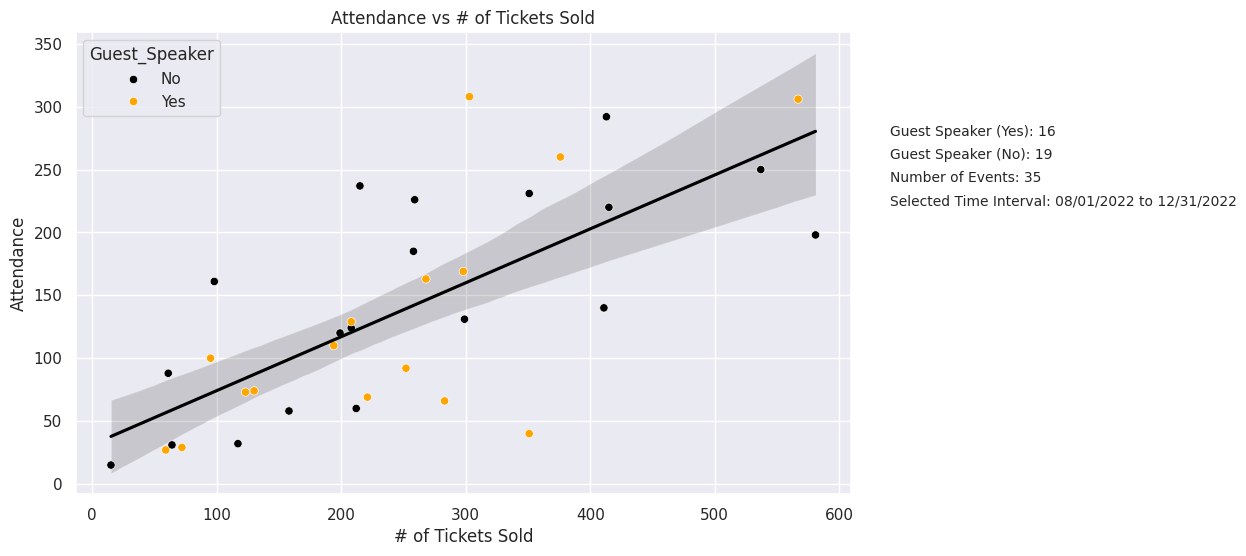

Event,All_Attendance,Ticket Quantity
AGNI at 50: A literary celebration,226,259
Celebrating 10 Years of Cognoscenti,124,208
Circle Round Book Launch Party II,250,537
A conversation on climate action and activism with environmentalist Bill McKibben,163,268
I'm Glad My Mom Died: #1 New York Times best-selling author Jennette McCurdy on her new memoir,308,303
README.txt: Whistleblower Chelsea Manning tells her story,100,95
The Stolen Year: NPR education correspondent Anya Kamenetz on how the pandemic changed children's lives,29,72
Endless Thread Presents: Rise of the Bots,60,212
Curated Cuisine: Art of the chicken with world-renowned chef Jacques Pépin,260,376
Curated Cuisine: Fishing in New England with Barton Seaver and Jeremy Sewall,73,123


In [17]:
# Function to update the plot and table based on the selected time interval
from IPython.display import display, HTML
def update_plot_and_table(start_date, end_date):
    filtered_df1 = df1[(df1['Date'] >= pd.Timestamp(start_date)) & (df1['Date'] <= pd.Timestamp(end_date))]

    # Update the plot
    plt.figure(figsize=(10, 6))
    sns.regplot(data=filtered_df1, x='Ticket Quantity', y='All_Attendance', color='black', scatter=False)
    sns.scatterplot(data=filtered_df1, x='Ticket Quantity', y='All_Attendance', hue='Guest_Speaker', palette={'Yes': 'orange', 'No': 'black'})
    plt.title('Attendance vs # of Tickets Sold')
    plt.xlabel('# of Tickets Sold')
    plt.ylabel('Attendance')
    start_date_str = start_date.strftime('%m/%d/%Y')
    end_date_str = end_date.strftime('%m/%d/%Y')
    guest_speaker_counts = filtered_df1['Guest_Speaker'].value_counts()
    plt.text(1.05, 0.8, f'Guest Speaker (Yes): {guest_speaker_counts.get("Yes", 0)}', transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top')
    plt.text(1.05, 0.75, f'Guest Speaker (No): {guest_speaker_counts.get("No", 0)}', transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top')
    num_events = len(filtered_df1)
    plt.text(1.05, 0.7, f'Number of Events: {num_events}', transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top')
    plt.text(1.05, 0.65, f'Selected Time Interval: {start_date_str} to {end_date_str}', transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top')
    plt.show()

    # Display the table
    display(HTML(filtered_df1[['Event', 'All_Attendance', 'Ticket Quantity']].to_html(index=False)))

# Call the update_plot_and_table function with the selected dates
update_plot_and_table(start_date_widget.value, end_date_widget.value)

# Plot 3: Finding most profitable events

This plot does not include events that are free

In [8]:
# Creating a df that only looks at non-free events
df2 = df1[df1['Total_Profit'] != 0.0]

In [18]:
def update_plot(selected_categories):
    avg_profit_selected = df2[df2['Category'].isin(selected_categories)].groupby(['Category', 'Guest_Speaker']).agg({'Total_Profit': 'mean', 'Category': 'size'}).rename(columns={'Category': 'Event_Count'}).reset_index()

    # Sort the dataframe by average profit in descending order
    avg_profit_selected_sorted = avg_profit_selected.sort_values(by='Total_Profit', ascending=False)

    fig = px.bar(avg_profit_selected_sorted, y='Category', x='Total_Profit', color='Guest_Speaker',
                 barmode='group', title='Average Total Profit by Category with Guest Speaker Comparison',
                 category_orders={"Category": selected_categories, "Guest_Speaker": ["Yes", "No"]},
                 hover_data={'Total_Profit': True, 'Event_Count': True},
                 labels={'Total_Profit': 'Average Total Profit', 'Event_Count': 'Event Count'},
                 template='plotly',
                 orientation='h',  # Set orientation to horizontal
                 color_discrete_map={'Yes': 'orange', 'No': 'black'})  # Set colors for Yes and No

    fig.show()

# Create checkboxes for categories
category_checkboxes = [widgets.Checkbox(description=category, value=False) for category in df2['Category'].unique()]

# Function to handle checkbox change event
def checkbox_event_handler(change):
    selected_categories = [checkbox.description for checkbox in category_checkboxes if checkbox.value]
    update_plot(selected_categories)

# Bind the event handler function to the checkboxes
for checkbox in category_checkboxes:
    checkbox.observe(checkbox_event_handler, names='value')

# Display the checkboxes vertically without extra space
category_checkboxes_vbox = widgets.VBox(category_checkboxes, layout={'display': 'flex', 'flex_flow': 'column'})
display(category_checkboxes_vbox)

In [19]:
update_plot([checkbox.description for checkbox in category_checkboxes if checkbox.value])